# Business Analysis Using SQL
## Introduction
In order to practice writing more complex queries and answer questions that would normally be quite difficult to answer without the use of SQL, we will be analyzing some basic business questions in this project. The database to be used is the popular chinook.db, holding data for a fictional music record store. Let's try to answer some questions that don't really jump out from just looking at the data as is.


## Creating Helper Functions
We can create some usefull functions in the notebook that get some tedious tasks out of the way and make things easier.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(query):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(query, conn)

def run_command(command):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(command)

def show_tables():
    query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(query)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


Here we see all the tables associated with our fictional business and the chinook database.

## Top Genres in the USA
Suppose we get tasked with this hypothetical question: Our chinook store has just signed a new deal, and we have to select the first three albums that will be added to the store from the new record label, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:
* Regal - Hip-Hop
* Red Tone - Punk
* Meteor and the Girls - Pop
* Slim Jim Bites - Blues

The record label specializes in artists from the USA, so it's best if we focus our analysis on their area of targets as well.

In [5]:
top_genres = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* 
    FROM invoice_line as il
    INNER JOIN invoice as i on il.invoice_id = i.invoice_id
    INNER JOIN customer as c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name as genre,
    count(uts.invoice_line_id) as tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) as percentage_sold
FROM usa_tracks_sold as uts
INNER JOIN track as t on t.track_id = uts.track_id
INNER JOIN genre as g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(top_genres)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


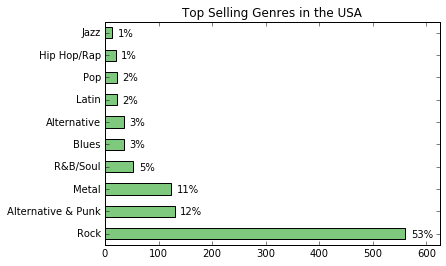

In [203]:
genre_sales_usa = run_query(top_genres)

genre_sales_usa.set_index("genre", inplace=True, drop=True)
genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

While the query writing looked complex, the end result of the visualization makes things so much easier! Based on this data, the three of four artists that we should choose to add to the store, in order, are:

* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Sales Support Agent Performance
Suppose we are tasked with analyzing the purchases of customers belonging to each employee to see if any sales support agent is better or worse than their counterparts. Perhaps, we might like to consider whether any extra columns from the employee table explain any variance we see, or whether the variance might instead be indicative of employee performance.

In [19]:
customer_sales = '''
    SELECT 
        c.customer_id,
        c.support_rep_id,
        SUM(i.total) as sales
    FROM customer as c
    INNER JOIN invoice as i on c.customer_id = i.customer_id
    GROUP BY 1
    LIMIT 10;

'''

run_query(customer_sales)

,customer_id,support_rep_id,sales
0,1,3,108.90
1,2,5,82.17
2,3,3,99.99
3,4,4,72.27
4,5,4,144.54
5,6,5,128.70
6,7,5,69.30
7,8,4,60.39
8,9,4,37.62
9,10,4,60.39


In [20]:
agent_sales = '''
WITH customer_sales AS
   (
    SELECT 
        c.customer_id,
        c.support_rep_id,
        SUM(i.total) as sales
    FROM customer as c
    INNER JOIN invoice as i on c.customer_id = i.customer_id
    GROUP BY 1
   )

SELECT
    e.first_name || " " || e.last_name as employee_name,
    e.reports_to,
    e.hire_date,
    SUM(cs.sales) as sales_total 
FROM employee as e
INNER JOIN customer_sales as cs on e.employee_id = cs.support_rep_id
GROUP BY 1
ORDER BY 4 DESC;
'''

run_query(agent_sales)

,employee_name,reports_to,hire_date,sales_total
0,Jane Peacock,2,2017-04-01 00:00:00,1731.51
1,Margaret Park,2,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2,2017-10-17 00:00:00,1393.92


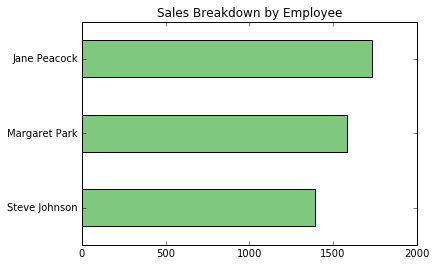

In [27]:
agent_performance = run_query(agent_sales)

agent_performance.set_index("employee_name", inplace=True, drop=True)
agent_performance.sort_values("sales_total", inplace=True)
agent_performance["sales_total"].plot.barh(
    title="Sales Breakdown by Employee",
    xlim=(0, 2000),
    colormap=plt.cm.Accent
)

plt.ylabel('')

plt.show()

From our visualization created, we can see that Jane Peakcock has the most sales. However, before giving her the best employee award, we have to look at some other details that were recorded in the query as well. All 3 sales agents report to the same supervisor, so there is no variance here. However, we see that Jane was hired a month before Margaret, and about 6 months before Steve! Therefore, she *should* have more sales than the other two by default. Taking the hire date into account, we see that no employee is outperforming any other to a statistically significant amount, and that all three are probaly upstanding (yes, the politically correct answer :)).

It is worth noting that the invoice dates go all the way up to 2020 in the invoice table, so depending on when you are viewing this project, Jane's performance may be seen as better or worse relative to the date (if the year is 2020 and Jane still has a 20% more sales total than Steve, this is good for Jane. If the year was still 2017, then Steve is a generational employee, it seems like).

## Sales Data by Country
Let's analyze the sales for customers by each customer. We will use the country value in the customers table, rather than the invoice table, as the billing country can be diferent than the actual customer's country. Namely, we'll look to compute these values for each country:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Note that there are some countries with only 1 customer, so we'll group these together in one "Other" column.

In [156]:
country_customers = '''
     SELECT
         CASE
             WHEN (
                  SELECT count(*)
                  FROM customer
                  WHERE country = c.country
                  ) = 1 THEN "Other"
           ELSE c.country
       END as country,
       c.customer_id,
       il.*
     FROM invoice_line as il
     INNER JOIN invoice as i on i.invoice_id = il.invoice_id
     INNER JOIN customer as c on c.customer_id = i.customer_id
     LIMIT 20;
'''

run_query(country_customers)

,country,customer_id,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,USA,18,1,1,1158,0.99,1
1,USA,18,2,1,1159,0.99,1
2,USA,18,3,1,1160,0.99,1
3,USA,18,4,1,1161,0.99,1
4,USA,18,5,1,1162,0.99,1
5,USA,18,6,1,1163,0.99,1
6,USA,18,7,1,1164,0.99,1
7,USA,18,8,1,1165,0.99,1
8,USA,18,9,1,1166,0.99,1
9,USA,18,10,1,1167,0.99,1


In [158]:
country_sales = '''
WITH country_customers AS
   (
     SELECT
         CASE
             WHEN (
                  SELECT count(*)
                  FROM customer
                  WHERE country = c.country
                  ) = 1 THEN "Other"
           ELSE c.country
       END as country,
       c.customer_id,
       il.*
     FROM invoice_line as il
     INNER JOIN invoice as i on i.invoice_id = il.invoice_id
     INNER JOIN customer as c on c.customer_id = i.customer_id
   )

SELECT
    country,
    total_customers,
    total_sales,
    average_order_value,
    average_sale_per_customer
FROM
    (
    SELECT
        country,
        count(distinct customer_id) as total_customers,
        SUM(unit_price) as total_sales,
        SUM(unit_price) / count(distinct customer_id) as average_sale_per_customer,
        SUM(unit_price) / count(distinct invoice_id) as average_order_value,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END as sort
    FROM country_customers
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(country_sales)

,country,total_customers,total_sales,average_order_value,average_sale_per_customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


There's a lot of data to digest here, so let's use more than one plot, preferably one for each dimension, to avoid clutter. Note: The "Other" group has weak implications all around, so there really is no need for us to include it in some of the visualization analysis, as it probably won't give much insight.

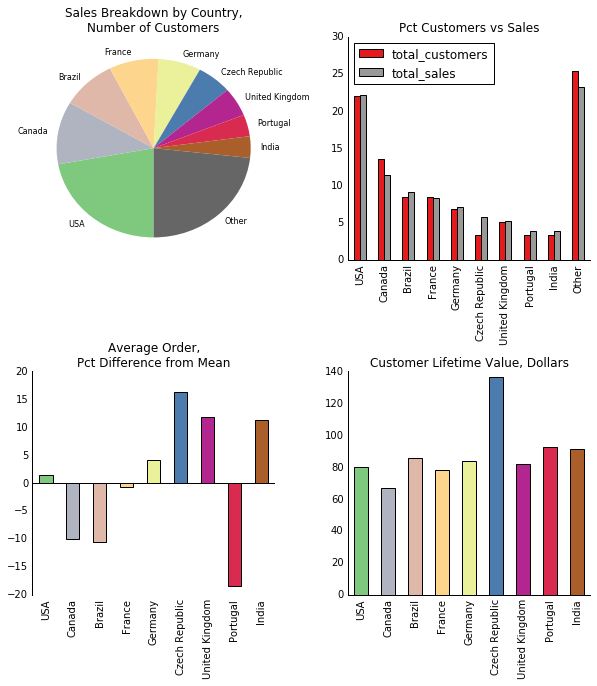

In [160]:
country_data = run_query(country_sales)
country_data.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_data.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_data["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["total_customers","total_sales"]
custs_vs_dollars = country_data[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_data["average_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_data["average_sale_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Now we can use this easier represented data to make some conclusions, namely which countries are worth marketing to. We see that the following countries havea very high average order, as well as high customer lifetime values:

* Czech Republic
* United Kingdom
* India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers. It is also worth noting what is determinant on being worthwhile. While These three counries have a high "per-customer" value, that doesn't change the fact that the majority of sales still come from the USA. It would be foolish to discontinue marketing in the USA and focusing solely on high average data points.

## Albums vs Individual Tracks
We can also do an analysis on what percantage of all purchases are whole albums vs. individual track purchases. This can be handy for the pricing department.

In [161]:
albums_vs_tracks = '''
WITH invoice_first_track as
    (
     SELECT
         il.invoice_id as invoice_id,
         MIN(il.track_id) as first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) as number_of_invoices,
    CAST(COUNT(invoice_id) as float) / (
                                         SELECT COUNT(*) FROM invoice
                                       ) as percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id 
                  FROM track as t
                  WHERE t.album_id = (
                                      SELECT t2.album_id 
                                      FROM track as t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id 
                  FROM invoice_line as il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id 
                  FROM invoice_line as il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id 
                  FROM track as t
                  WHERE t.album_id = (
                                      SELECT t2.album_id 
                                      FROM track as t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END as "album_purchase"
     FROM invoice_first_track as ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


There is no need for a visualization with only a 2x3 display of results here, but it is clearly easy to see that we should b wary of doing anything in terms of pricing with albums, because although people buy individual tracks a lot more frequently, full album purchases still account for about 20% of all revenue.

## Further Analysis
Queries can be complex or easy, but the results should always be easy to read! While the last query involving albums vs. tracks looked relatively complex, answering questions should always be taken as simply as possible. This is good both for readibility and also effieciency. Below we try to answer such questions.

## Most Popular Artist
We can determine things like which artist is being used in the most playlists. This can be interesting to see for marketing purposes.

In [165]:
artist_playlist = '''
SELECT 
    a.name,
    COUNT(p.playlist_id) as count
FROM playlist as p
INNER JOIN playlist_track as pt on pt.playlist_id = p.playlist_id
INNER JOIN track as t on t.track_id = pt.track_id
INNER JOIN album as al on al.album_id = t.album_id
INNER JOIN artist as a on a.artist_id = al.artist_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 20;
'''

run_query(artist_playlist)

,name,count
0,Iron Maiden,516
1,U2,333
2,Metallica,296
3,Led Zeppelin,252
4,Deep Purple,226
5,Lost,184
6,Pearl Jam,177
7,Eric Clapton,145
8,Faith No More,145
9,Lenny Kravitz,143


Remembering our most popular genre query from above, this result should not come as a surprise. It is worth noting that the most popular artist in playlists, Iron Maiden, comes in at almost double the #2 spot!

## How Many Purchased vs. Not Purchased Tracks
We can get rid of some inventory that's collecting dust by determining which tracks are not being bought in the store.

In [208]:
purchased = '''
SELECT
    total,
    purchased,
    total - purchased as not_puchased,
    CAST(purchased as float) / CAST(total as float) as percent_purchased
FROM (
     SELECT
         COUNT(DISTINCT t.track_id) as total,
         COUNT(DISTINCT il.track_id) as purchased
     FROM track as t
     LEFT JOIN invoice_line as il on il.track_id = t.track_id
     );
'''

run_query(purchased)

,total,purchased,not_puchased,percent_purchased
0,3503,1806,1697,0.515558


Wow! Almost 50% of tracks are never purchased! This kind of makes sense as individual tracks accunt for 80% of sales as seen before, so people may just be targetting popular tracks, but even if 20% of all sales are albums, keeping 50% of your inventory to collect dust is not a good idea! This better be reported.

## Range of Tracks vs. Popularity
Earlier, we saw the most popular genres in sales. But this does not necessarily mean the store is doing its due diligence to keep up with this popularity. Does their inventory match the range of their most popular genres? To answer this, we can look at sales in the USA to compare with the earlier findings.

In [198]:
top_inventory = '''
SELECT
    g.name as genre,
    COUNT(g.name) as count,
    CAST(COUNT(g.name) as float) / (
                                   SELECT 
                                       CAST(COUNT(t.track_id) as float) as percentage
                                   FROM track as t
                                   ) as percentage
FROM genre as g
INNER JOIN track as t on t.genre_id = g.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(top_inventory)

,genre,count,percentage
0,Rock,1297,0.370254
1,Latin,579,0.165287
2,Metal,374,0.106766
3,Alternative & Punk,332,0.094776
4,Jazz,130,0.037111
5,TV Shows,93,0.026549
6,Blues,81,0.023123
7,Classical,74,0.021125
8,Drama,64,0.018270
9,R&B/Soul,61,0.017414


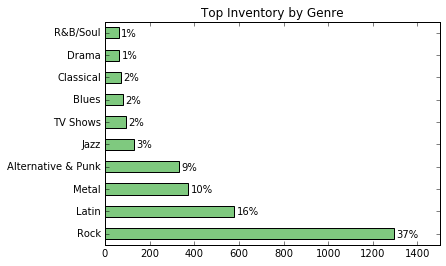

In [207]:
inventory = run_query(top_inventory)

inventory.set_index("genre", inplace=True, drop=True)
inventory["count"].plot.barh(
    title="Top Inventory by Genre",
    xlim=(0, 1500),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(inventory.index)):
    score = inventory.loc[label, "count"]
    label = (inventory.loc[label, "percentage"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

As we can see, although the store has the most popular genre right (thank god), there are a few discrepencies in terms of genres. Latin is not popular at all (at least for the US), yet it accounts for 16% of all inventory. Similarly, R&B/Soul is quite popular for US sales, yet it only accunts for 1% of inventory! Obviously, we would need to run the sales query for the world (just simply remove the USA criteria) in order to make conclusions, but as it stands, there seems to be a little need for inventory renewal.

## Protected vs. Non-Protected Media 
Lastly, we will take a look at whether or not being a protected or non-protected media type has any indication on sales. We can write a query for this, but actually, if we take an existing one and modify it slightly we will get our answer (the purchased vs. non-purchased one). Note that protected media types are of ID 2,3, and non-protected are 1,4,5 (a simple select * query will show this):

In [212]:
protected = '''
SELECT
    purchased,
    protected,
    purchased - protected as not_protected,
    CAST(protected as float) / CAST(purchased as float) as percent_protected
FROM (
     SELECT
         COUNT(DISTINCT il.track_id) as purchased,
         SUM(CASE WHEN m.media_type_id IN (2,3) THEN 1 ELSE 0 END) as protected
     FROM invoice_line as il
     INNER JOIN track as t on t.track_id = il.track_id
     INNER JOIN media_type as m on m.media_type_id = t.media_type_id
     );
'''

run_query(protected)

,purchased,protected,not_protected,percent_protected
0,1806,442,1364,0.24474


In [217]:
protected_count = '''
SELECT media_type_id, COUNT(track_id) as count
FROM track
GROUP BY 1;
'''

run_query(protected_count)

,media_type_id,count
0,1,3034
1,2,237
2,3,214
3,4,7
4,5,11


From our first result, we see that non-protected media types actually account for about 75% of sales, which would deem them more popular. However, it is always important to ask more questions and dig deeper if something seems fishy. Using a very quick analysis of tracks, we see that media type 1 actually accounts for over 75% of all tracks by itself! Since type 1 is not protected, we see where the discrepency comes from. Using this information, we can determine that media types do not really have an effect on overall popularity.

## Conclusion
In this project, even though we were using a fictional database and store, we could still analyze very important questions, and, had this been a real store, we would've saved a lot of money by the end of the day today! This project showed that by using queries, not matter how complex or simple, we can get some very important data in a very readible fashion relatively quickly; such is the power of the combination of Python and SQL. Using this analysis as an example, if such a fictional store were to actually exist, it would be in very good standing after these changes were applied!